In [35]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

In [36]:
# Define paths based on your structure
base_path = "./dataset/"
train_dir = os.path.join(base_path, "images/train")
test_dir = os.path.join(base_path, "images/test")
train_annos = os.path.join(base_path, "cars_train_annos.mat")
test_annos = os.path.join(base_path, "cars_test_annos_withlabels.mat")

In [37]:
# Load pretrained DeepLabV3 (trained on COCO with 21 classes)
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval()

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [38]:
# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(520),  # Resize shorter side to 520
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [39]:
class StanfordCarsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_path, mode="train"):
        self.root_dir = root_dir
        self.annotations = loadmat(annotations_path)["annotations"][0]
        self.mode = mode

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        # Extract filename, bbox, and class
        img_name = anno[-1].item()  # Last field is filename
        bbox = (anno[0].item(), anno[1].item(), anno[2].item(), anno[3].item())  # x1, y1, x2, y2
        class_label = anno[4].item() if self.mode == "train" else anno[5].item()  # Test has labels in 5th field
        
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        return image, bbox, class_label

In [40]:
# Initialize dataset (test set example)
dataset = StanfordCarsDataset(
    root_dir=test_dir,
    annotations_path=test_annos,
    mode="test"
)

In [41]:
def get_car_color_median(image, bbox):
    """Same as before, but no need to crop (dataset provides bbox)"""
    x1, y1, x2, y2 = bbox
    cropped_img = image.crop((x1, y1, x2, y2))
    
    input_tensor = preprocess(cropped_img).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    
    mask = torch.argmax(output, dim=0).numpy() == 7  # COCO "car" class
    
    mask = Image.fromarray(mask.astype(np.uint8)).resize(cropped_img.size)
    mask = np.array(mask)
    
    car_pixels = np.array(cropped_img)[mask.astype(bool)]
    return np.median(car_pixels, axis=0) if car_pixels.size > 0 else None

In [42]:
def get_car_color_mean(image, bbox):
    """Same as before, but no need to crop (dataset provides bbox)"""
    x1, y1, x2, y2 = bbox
    cropped_img = image.crop((x1, y1, x2, y2))
    
    input_tensor = preprocess(cropped_img).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    
    mask = torch.argmax(output, dim=0).numpy() == 7  # COCO "car" class
    
    mask = Image.fromarray(mask.astype(np.uint8)).resize(cropped_img.size)
    mask = np.array(mask)
    
    car_pixels = np.array(cropped_img)[mask.astype(bool)]
    return np.mean(car_pixels, axis=0) if car_pixels.size > 0 else None

In [57]:
# Example usage
idx = 4  # Try different indices
image, bbox, label = dataset[idx]
median_color = get_car_color_median(image, bbox)
mean_color = get_car_color_mean(image, bbox)

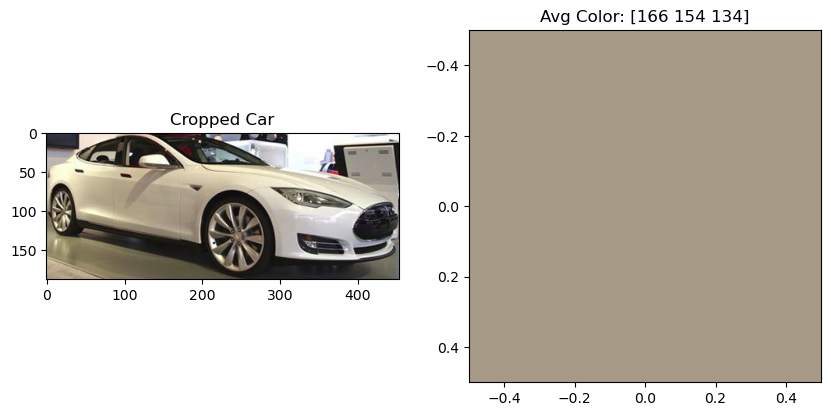

In [58]:
# Visualization Median
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.crop(bbox))
plt.title("Cropped Car")

plt.subplot(1, 2, 2)
if average_color is not None:
    plt.imshow([[median_color.astype(int)]])
    plt.title(f"Avg Color: {median_color.astype(int)}")
else:
    plt.text(0.5, 0.5, "No car pixels detected", ha='center')
plt.show()

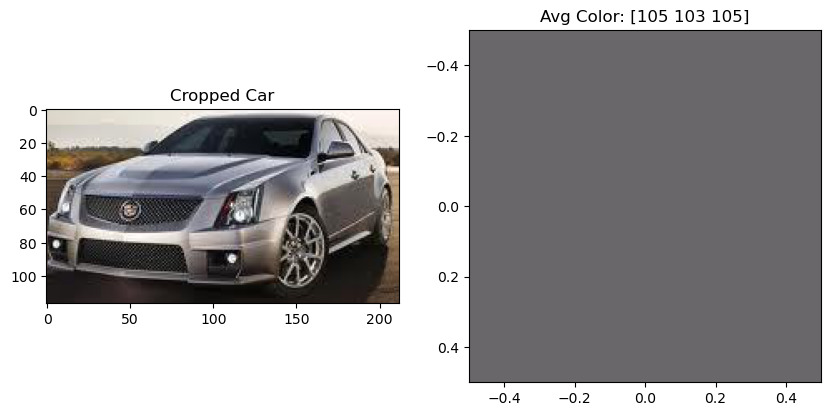

In [46]:
# Visualization Mean
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.crop(bbox))
plt.title("Cropped Car")

plt.subplot(1, 2, 2)
if average_color is not None:
    plt.imshow([[mean_color.astype(int)]])
    plt.title(f"Avg Color: {mean_color.astype(int)}")
else:
    plt.text(0.5, 0.5, "No car pixels detected", ha='center')
plt.show()

In [32]:
dataset.annotations

array([(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array([[181]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
       (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array([[103]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
       (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array([[145]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
       ...,
       (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array([[17]], dtype=uint8), array(['08039.jpg'], dtype='<U9')),
       (array([[33]], dtype=uint8), array([[142]], dtype=uint8), array([[521]], dtype=uint16), array([[376]], dtype=uint16), array([[38]], dtype=uint8), array(['08040.jpg'], dtype='<U9')),
       (array([[77]], dtype=uint8), array([[73

In [27]:
dataset[idx]

(<PIL.Image.Image image mode=RGB size=1024x683>,
 (168, 172, 877, 592),
 '00043.jpg')